In [1]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.stimulus_analysis import StimulusAnalysis
from stimulus_analysis.drifting_gratings import DriftingGratings
from stimulus_analysis import fit_utils
import analysis_tools as at

at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/AllenDrive/v1dd/data" # Chase's external hard drive
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = V1DDClient(base_folder)

In [3]:
metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)

# Only consider valid metrics
print(f"{np.count_nonzero(metrics.is_valid)}/{len(metrics)} ({np.mean(metrics.is_valid)*100:.1f}%) ROIs are valid")
metrics = metrics[metrics.is_valid & (metrics.mouse == 409828) & (metrics.column == 1)]

metrics.head()

9714/52826 (18.4%) ROIs are valid


,mouse,column,volume,plane,roi,is_valid,depth,dgf_pref_response,dgf_pref_dir,dgf_pref_sf,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_1_89,409828,1,1,1,89,True,50,0.000943,330.0,0.08,...,0.000450,0.000710,0.000586,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903
M409828_11_2_0,409828,1,1,2,0,True,66,0.000919,270.0,0.08,...,0.000653,0.000394,0.000911,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629
M409828_11_2_1,409828,1,1,2,1,True,66,0.011217,0.0,0.08,...,0.000538,0.002046,0.009295,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262
M409828_11_2_2,409828,1,1,2,2,True,66,0.001237,120.0,0.04,...,0.000582,0.000344,0.000369,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412
M409828_11_2_4,409828,1,1,2,4,True,66,0.001093,240.0,0.04,...,0.000381,0.000221,0.000660,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601


In [4]:
# Insert new metrics columns for analysis
def f_depth_chunk(row):
    depth_chunk = int(np.floor((row.depth - 50) / 48)) # 50 is shallowest depth; 48 is size of chunk
    if depth_chunk > 10:
        depth_chunk = 10 # deeper chunks to go 10
    return depth_chunk

metrics["depth_chunk"] = metrics.apply(f_depth_chunk, axis=1)
metrics["vol_plane"] = metrics.apply(lambda row: f"{row.volume}-{row.plane}", axis=1)
print("depth_chunk value counts:")
metrics["depth_chunk"].value_counts().sort_index()

depth_chunk value counts:


0       36
1      551
2      985
3     1081
4     1362
5     1346
6     1307
7      910
8      623
9      589
10     924
Name: depth_chunk, dtype: int64

In [5]:
metrics.columns

Index(['mouse', 'column', 'volume', 'plane', 'roi', 'is_valid', 'depth',
       'dgf_pref_response', 'dgf_pref_dir', 'dgf_pref_sf', 'dgf_pref_dir_idx',
       'dgf_pref_sf_idx', 'dgf_pref_dir_mean', 'dgf_z_score', 'dgf_response_p',
       'dgf_osi', 'dgf_gosi', 'dgf_dsi', 'dgf_frac_responsive_trials',
       'dgf_lifetime_sparseness', 'dgf_p_trial_responses',
       'dgf_sig_trial_responses', 'dgf_vonmises_0_param_0',
       'dgf_vonmises_0_param_1', 'dgf_vonmises_0_param_2',
       'dgf_vonmises_0_param_3', 'dgf_vonmises_0_param_4',
       'dgf_vonmises_0_param_5', 'dgf_vonmises_0_pref_dir',
       'dgf_vonmises_0_peak_amp', 'dgf_vonmises_0_r2_score',
       'dgf_vonmises_1_param_0', 'dgf_vonmises_1_param_1',
       'dgf_vonmises_1_param_2', 'dgf_vonmises_1_param_3',
       'dgf_vonmises_1_param_4', 'dgf_vonmises_1_param_5',
       'dgf_vonmises_1_pref_dir', 'dgf_vonmises_1_peak_amp',
       'dgf_vonmises_1_r2_score', 'dgf_norm_dir_responses', 'dgf_pref_ori',
       'dgf_chisq_respons

In [6]:
[x for x in metrics.columns if "ssi" in x]

['ssi', 'ssi_pref_both', 'ssi_orth']

In [7]:
metrics["ssi_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics)
metrics["dgw_vonmises_r2_score"] = fit_utils.get_dg_r2_score(metrics, "dgw")
metrics["dgf_vonmises_r2_score"] = fit_utils.get_dg_r2_score(metrics, "dgf")
metrics.insert(5, "roi_lookup", metrics.apply(lambda row: f"{row.column}-{row.volume}-{row.plane}-{row.roi}", axis=1))

(-1.0263774037361144,
 1.096494162082672,
 -1.033385440032918,
 1.0968278780968057)

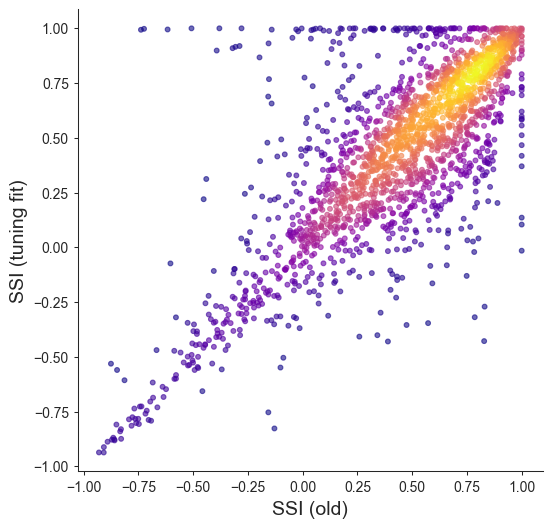

In [8]:
x = metrics.ssi
y = metrics.ssi_fit

include = np.isfinite(x) & np.isfinite(y) & (metrics.dgw_frac_responsive_trials >= 0.5)

at.density_scatter(
    x[include], y[include],
    xlabel="SSI (old)",
    ylabel="SSI (tuning fit)",
    figsize=(6, 6),
).axis("equal")

<AxesSubplot: xlabel='SSI (old)', ylabel='SSI (tuning fit)'>

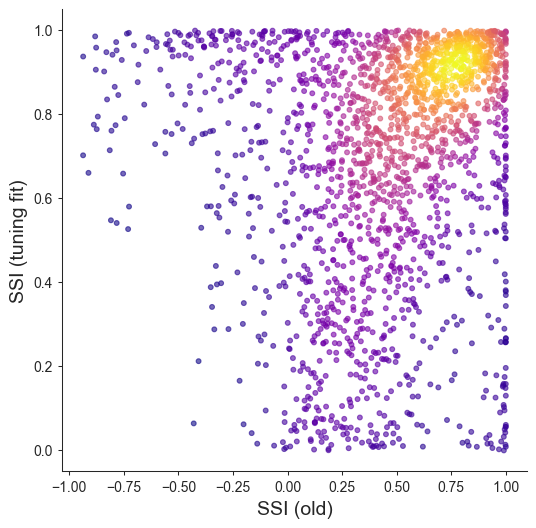

In [9]:
x = metrics.ssi_fit
y = metrics.dgw_vonmises_r2_score

include = metrics.dgw_frac_responsive_trials >= 0.5

at.density_scatter(
    x[include], y[include],
    xlabel="SSI (old)",
    ylabel="SSI (tuning fit)",
    figsize=(6, 6),
)

<AxesSubplot: xlabel='ssi_fit', ylabel='depth_chunk'>

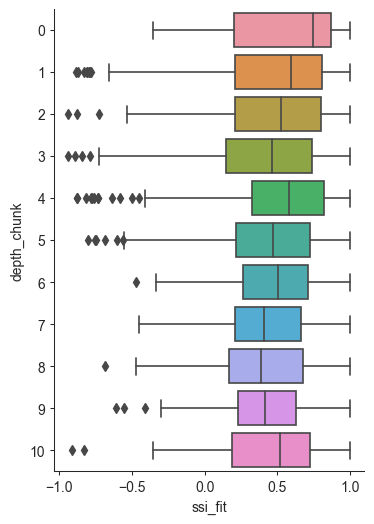

In [10]:
plt.figure(figsize=(4, 6))
sns.boxplot(data=metrics[(metrics.dgw_frac_responsive_trials >= 0.5)], x="ssi_fit", y="depth_chunk", orient="h")

<AxesSubplot: xlabel='dgw_osi', ylabel='depth_chunk'>

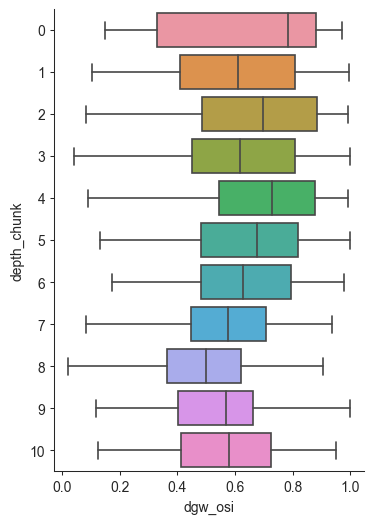

In [11]:
plt.figure(figsize=(4, 6))
sns.boxplot(data=metrics[(metrics.dgw_frac_responsive_trials >= 0.5)], x="dgw_osi", y="depth_chunk", orient="h")

<AxesSubplot: xlabel='dgw_dsi', ylabel='depth_chunk'>

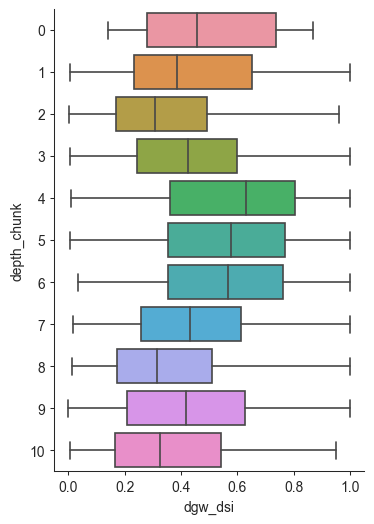

In [12]:
plt.figure(figsize=(4, 6))
sns.boxplot(data=metrics[(metrics.dgw_frac_responsive_trials >= 0.5)], x="dgw_dsi", y="depth_chunk", orient="h")

<AxesSubplot: xlabel='dgw_frac_responsive_trials', ylabel='depth_chunk'>

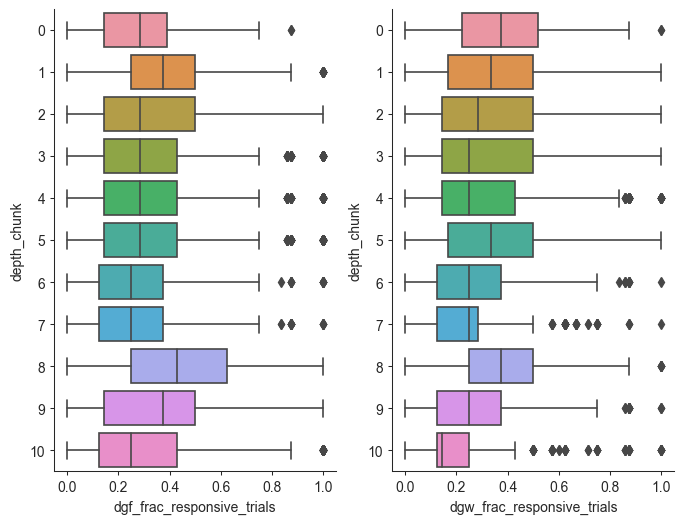

In [13]:
fig, axs = plt.subplots(figsize=(8, 6), ncols=2)
sns.boxplot(data=metrics, x="dgf_frac_responsive_trials", y="depth_chunk", orient="h", ax=axs[0])
sns.boxplot(data=metrics, x="dgw_frac_responsive_trials", y="depth_chunk", orient="h", ax=axs[1])

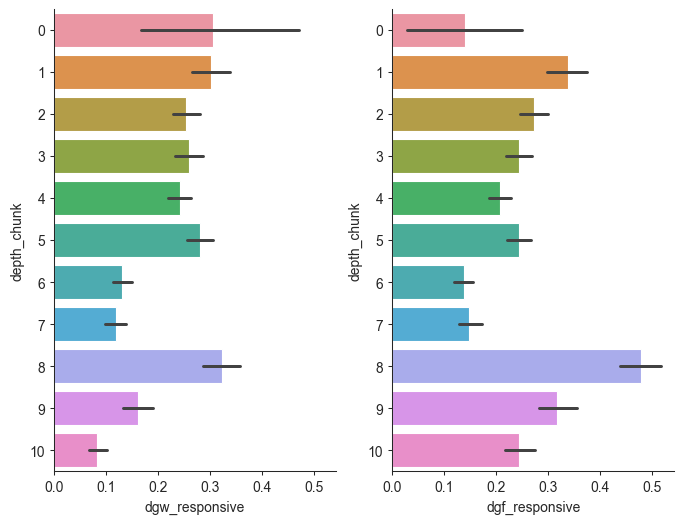

In [15]:
metrics["dgw_responsive"] = metrics["dgw_frac_responsive_trials"] >= 0.5
metrics["dgf_responsive"] = metrics["dgf_frac_responsive_trials"] >= 0.5

# df = metrics.groupby("depth_chunk")[["dgw_responsive", "dgf_responsive"]].mean().reset_index()
fig, axs = plt.subplots(figsize=(8, 6), ncols=2)

sns.barplot(data=metrics, x="dgw_responsive", y="depth_chunk", orient="h", ax=axs[0])
sns.barplot(data=metrics, x="dgf_responsive", y="depth_chunk", orient="h", ax=axs[1])

# Same xlim
xmax = max(ax.get_xlim()[1] for ax in axs)
for ax in axs: ax.set_xlim(0, xmax)

## Look at SSI vs. horizontal distance in plane

In [31]:
sess = client.load_ophys_session(mouse=409828, column=1, volume=3)

In [32]:
metrics["roi_loc_x"] = np.nan
metrics["roi_loc_y"] = np.nan

mouse, col, vol = sess.get_mouse_column_volume()
for plane in sess.get_planes():
    for roi in sess.get_rois(plane):
        if not sess.is_roi_valid(plane, roi):
            continue
    
        idx = f"M{mouse}_{col}{vol}_{plane}_{roi}"
        mask = sess.get_roi_image_mask(plane, roi)
        w = np.where(mask)
        metrics.at[idx, "roi_loc_x"] = np.median(w[1])
        metrics.at[idx, "roi_loc_y"] = np.median(w[0])

metrics["dgw_tuning_pref_dir"] = fit_utils.get_dg_pref_dir(metrics, "dgw")

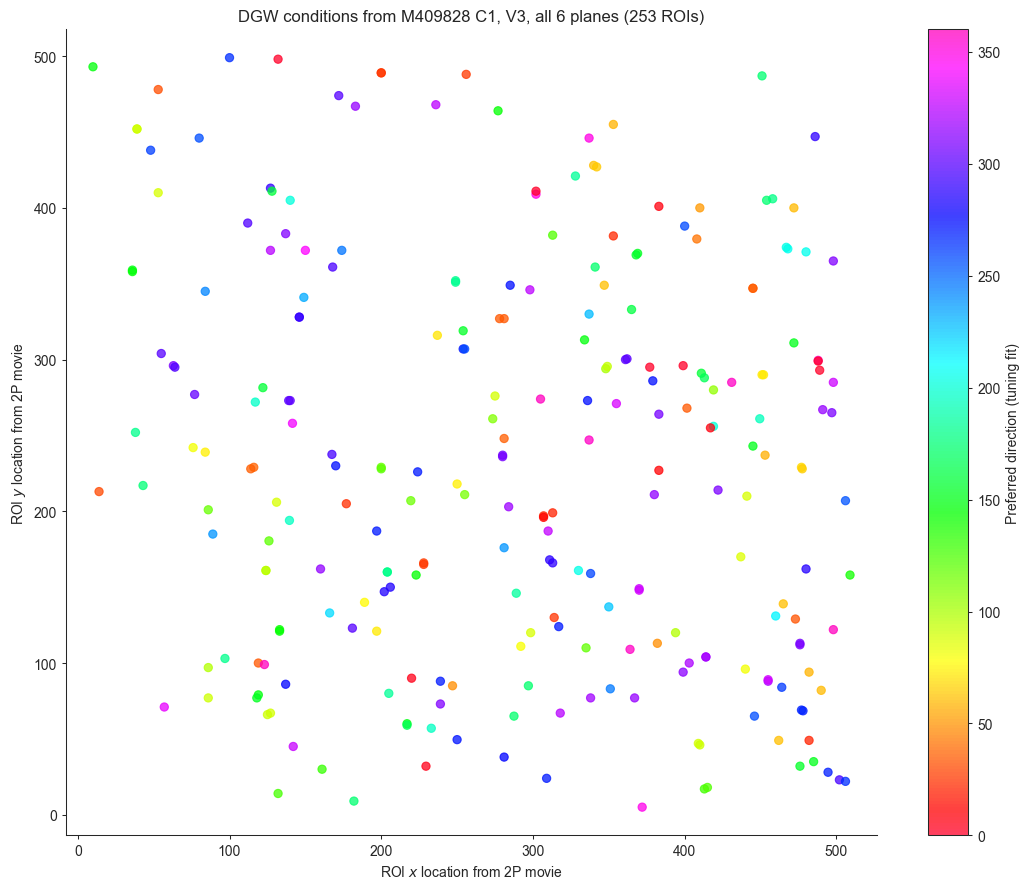

In [52]:
fig, ax = plt.subplots(figsize=(11, 9))

x, y = metrics.roi_loc_x, metrics.roi_loc_y
c, cmap = metrics.dgw_tuning_pref_dir, "gist_rainbow"
# c, cmap = metrics.ssi_fit, "cool"
inc = ~np.isnan(x) & (metrics.dgw_frac_responsive_trials >= 0.5) & (metrics.plane.isin([3, 4]))
n_rois = np.count_nonzero(inc)
s = ax.scatter(x[inc], y[inc], c=c[inc], s=35, alpha=0.75, cmap=cmap)
ax.axis("equal")
cbar = fig.colorbar(s)
cbar.set_label("Preferred direction (tuning fit)")
ax.set_title(f"DGW conditions from M{sess.get_mouse_id()} C{sess.get_column_id()}, V{sess.get_volume_id()}, all {len(sess.get_planes())} planes ({n_rois} ROIs)")
# ax.set_title(f"DGW conditions from M{sess.get_mouse_id()} C{sess.get_column_id()}, V{sess.get_volume_id()}, planes 1 and 2")
ax.set_xlabel("ROI $x$ location from 2P movie")
ax.set_ylabel("ROI $y$ location from 2P movie")
fig.tight_layout()

In [37]:
len(inc.index[inc.values])


709

In [44]:
pixel_radius_sq = 50 ** 2
roi_ssi = []
mean_nearby_ssi = []
# metric_name = "dgw_tuning_pref_dir"
metric_name = "ssi_fit"

inc_rois = inc.index[inc.values]

for roi in tqdm(inc_rois):
    nearby_ssi = 0
    n_nearby = 0
    x0, y0 = metrics.at[roi, "roi_loc_x"], metrics.at[roi, "roi_loc_y"]

    for nearby_roi in inc_rois:
        x1, y1 = metrics.at[nearby_roi, "roi_loc_x"], metrics.at[nearby_roi, "roi_loc_y"]

        if (x0-x1)**2 + (y0-y1)**2 <= pixel_radius_sq:
            nearby_ssi += metrics.at[nearby_roi, metric_name]
            n_nearby += 1
    
    if n_nearby > 0:
        roi_ssi.append(metrics.at[roi, metric_name])
        mean_nearby_ssi.append(nearby_ssi / n_nearby)

  0%|          | 0/709 [00:00<?, ?it/s]

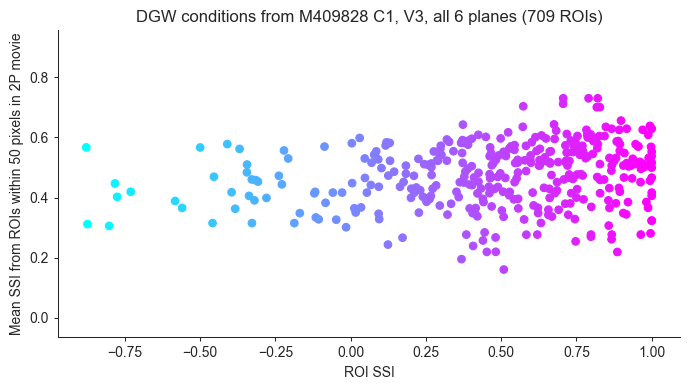

In [45]:
fig, ax = plt.subplots(figsize=(7, 4))

s = ax.scatter(roi_ssi, mean_nearby_ssi, c=roi_ssi, s=30, alpha=1, cmap="cool")
ax.axis("equal")
cbar.set_label("Preferred direction (tuning fit)")
ax.set_title(f"DGW conditions from M{sess.get_mouse_id()} C{sess.get_column_id()}, V{sess.get_volume_id()}, all {len(sess.get_planes())} planes ({len(roi_ssi)} ROIs)")
# ax.set_title(f"DGW conditions from M{sess.get_mouse_id()} C{sess.get_column_id()}, V{sess.get_volume_id()}, planes 1 and 2")
ax.set_xlabel("ROI SSI")
ax.set_ylabel("Mean SSI from ROIs within 50 pixels in 2P movie")
fig.tight_layout()